In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.core.pylabtools as pylabtools # for figsize
import seaborn as sns



def mask_data(data,*args):
    mask_and=np.array(args).all(0)
    return data[mask_and]

/Users/borundev/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Time series analysis: No external data

In [ ]:
data=pd.read_csv("processed_data.csv")
data['date']=pd.to_datetime(data.date)

In [ ]:
# since we want to make a time series in hours we need to make each "observation" or row correspond to a unique "hour"

data['delta_date']=(data.date-data.date[0])
data['delta_date']=map(lambda x : x.days,data.delta_date)

data['delta_time']=data.delta_date*24+data.time
data['delta_time']=map(lambda x: int(x),data.delta_time)

# since the original time includes minutes and we do not care about it we floor it
data['time_bin']=map(lambda x: int(x),data.time)

In [ ]:
# fill in FIPMINTOTAL with mean for missing values
data.loc[data.FIPMINTOTAL.isnull(),'FIPMINTOTAL']=data.FIPMINTOTAL.mean()

## Dont run anything below this till the place a similar comment tells you to run

In [ ]:
# For a time series analysis we cannot use other variables not related to date (we could include time and make the 
# intervals in hours instead of day but ultimatel the only fundamental information). Of course we can later add variables
# like the weather that are functions of the date

# If we want to analyze locations  (u'SECT_GEO_PEC', u'SECT_GEO_2_PEC') for instance we will have to do individual time series
# If we suspect cross correlations (and I don't) we could then look for those.


# create a new data frame that has the total calls for given unique hour given by 'delta_time' i.e. number of hours
# since the beginnning of the data set

columns_to_use=['date','month','day','time_bin','delta_date','delta_time'] 
nd=pd.DataFrame({'total' : data.groupby( columns_to_use).size()}).reset_index()


In [ ]:
nd

In [ ]:
# since everything is identified by 'delta_time' we make it the index
nd=nd.set_index('delta_time')

# and since some data must be missing we need to reindex
# when we include ambulance engagement we will need an extra date so +2 instead of +1
nd=nd.reindex(range(nd.index.max()+2))

# and check if something is missing
nd.head()

In [ ]:
nd.tail()

In [ ]:
# we now fill in the empty rows date, month, day and time_bin all uniquely identified by the index which is delta_time

start_date=nd.iloc[0].date

for index in nd[pd.isnull(nd.date)].index:
    nd.loc[index,'date']=start_date+pd.Timedelta(days=index/24)
    nd.loc[index,'month']=nd.loc[index,'date'].month
    nd.loc[index,'day']=pd.datetime.weekday(nd.loc[index,'date'])
    nd.loc[index,'time_bin']=np.mod(index,24)

nd['delta_date']=nd.index/24

In [ ]:
# Now we impute the missing values for total. This is NOT the best way to do it. We could take averages
# based on week and time of day for instance

nd.loc[nd.total.isnull(),'total']=int(nd.total.mean()) # should have a better way to impute

# make sure the last row total is zero as it was added fictitiously (see above)
nd.loc[87672,'total']=0

In [ ]:
# check that the missing values are filled
nd.tail(10)

In [ ]:
# we drop delta_time and delta_date as we do not need them anymore. In principle we do not need 'date' anymore either
# but we keep it just to make sure nothing has gotten scrambled at some later point
nd=nd.reset_index()
nd_cleaned=nd.drop(['delta_date'],axis=1)

In [ ]:
nd_cleaned.head()

In [ ]:
nd.month=nd.month.astype(int)
nd.day=nd.day.astype(int)
nd.time_bin=nd.time_bin.astype(int)

In [ ]:
# at this processed data so as not to have to do it again
nd.to_csv("classification_by_hour_data.csv",index=False)

In [ ]:
# if nothing is changed above we start from here
nd=pd.read_csv("classification_by_hour_data.csv")

In [ ]:
data[['time_bin','FIPMINTOTAL']].head()

In [ ]:
data['end_time_bin']=data['delta_time']+data.FIPMINTOTAL/60
data['end_time_bin']=data['end_time_bin'].astype(int)

In [ ]:
data[['time_bin','FIPMINTOTAL','end_time_bin']].head()

In [ ]:
data.end_time_bin.describe()

In [ ]:
nd.delta_time.describe()

In [ ]:
nd['number_ambulances_engaged']=0
nd['total_calls']=0
print data.shape[0]

for i in range(data.shape[0]):
    if i % 1000==0:
        print i
    s=data.iloc[i].delta_time
    e=data.iloc[i].end_time_bin
    nd.loc[s,'total_calls']=nd.loc[s,'total_calls']+1
    for k in range(s,e+1):
        nd.loc[k,'number_ambulances_engaged']=nd.loc[k,'number_ambulances_engaged']+1

In [ ]:
1.0*np.sum(nd.number_ambulances_engaged<nd.total)/nd.shape[0] # how can this happen?

In [ ]:
nd.number_ambulances_engaged.describe()

In [ ]:
for i in range(87673):
    if i%1000==0:
        print i
    nd.loc[i,'total_calls']=np.sum(data.delta_time==i)

In [ ]:
nd

In [ ]:
1.0*np.sum(nd.number_ambulances_engaged<nd.total_calls)/nd.shape[0] # how can this happen?

In [ ]:
# at this processed data so as not to have to do it again
nd.to_csv("classification_by_hour_data_2.csv",index=False)

## Start running from here

In [40]:
nd=pd.read_csv("classification_by_hour_data_2.csv")
nd.head()

,delta_time,date,month,day,time_bin,delta_date,total,number_ambulances_engaged,total_calls
0,0,2004-01-01,1,3,0,0,6,6,6
1,1,2004-01-01,1,3,1,0,6,9,6
2,2,2004-01-01,1,3,2,0,2,3,2
3,3,2004-01-01,1,3,3,0,3,3,3
4,4,2004-01-01,1,3,4,0,2,2,2


In [41]:
nd['total']=nd.number_ambulances_engaged # if we want total_calls change this to total calls
nd_cleaned=nd

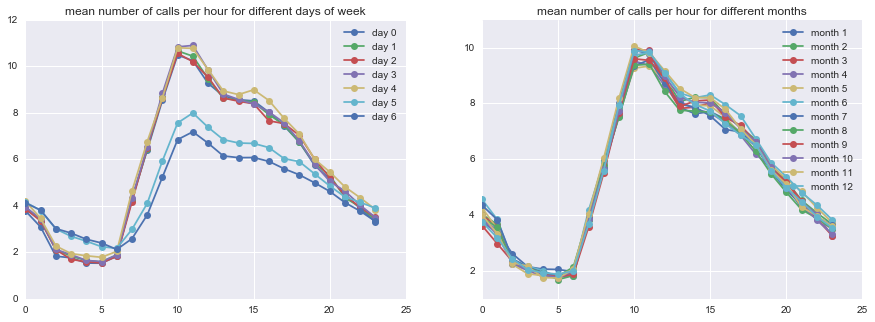

In [42]:
# we plot the behavior of mean number of calls by the hour for weekdays and months

pylabtools.figsize(15,5)
plt.subplot(121)
nd_mean=nd_cleaned.groupby(['day','time_bin']).mean().reset_index().drop('month',axis=1)
for i in range(7):
    data_masked=mask_data(nd_mean,nd_mean.day==i)
    plt.plot(data_masked.time_bin,data_masked.total,"-o",label="day "+str(i))
plt.title("mean number of calls per hour for different days of week")
plt.legend()

plt.subplot(122)
nd_mean=nd_cleaned.groupby(['month','time_bin']).mean().reset_index().drop('day',axis=1)
for i in range(1,13):
    data_masked=mask_data(nd_mean,nd_mean.month==i)
    plt.plot(data_masked.time_bin,data_masked.total,"-o",label="month "+str(i))
plt.title("mean number of calls per hour for different months")
plt.legend()

In [43]:
# we calculate a dataframe with this information
nd_mean=nd_cleaned.groupby(['month','day','time_bin']).mean().reset_index().drop(['delta_time','delta_date','number_ambulances_engaged','total_calls'],axis=1)

nd_mean.columns=['month','day','time_bin','mu']
nd_mean.head()

,month,day,time_bin,mu
0,1,0,0,3.377778
1,1,0,1,3.088889
2,1,0,2,2.311111
3,1,0,3,1.733333
4,1,0,4,1.822222


In [44]:
# merge the two data frame
nd_merged=nd_cleaned.merge(nd_mean,left_on=['month','day','time_bin'],right_on=['month','day','time_bin'])

In [45]:
# and see how it looks
nd_merged.sort_values(by='delta_time',inplace=True)
nd_merged.index=nd_merged.delta_time.values
nd_merged[['delta_time','time_bin','total','mu']].head()

,delta_time,time_bin,total,mu
0,0,0,6,3.727273
1,1,1,9,3.431818
2,2,2,3,2.386364
3,3,3,3,2.045455
4,4,4,2,1.863636


In [46]:
cond1=np.array([nd_merged.total.values>13,nd_merged.time_bin.values>=8,nd_merged.time_bin.values<20]).all(0)
cond2=np.array([nd_merged.total.values>9,nd_merged.time_bin.values<8]).all(0)
cond3=np.array([nd_merged.total.values>9,nd_merged.time_bin.values>=20]).all(0)
combined_condition=np.array([cond1,cond2,cond3]).any(0)

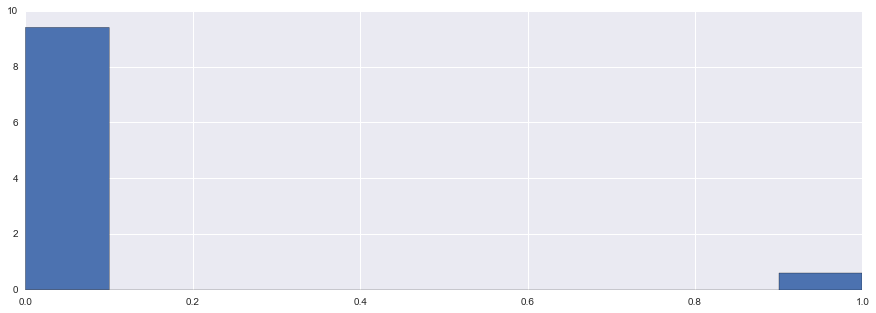

In [47]:

# another approach would be to ask if there is some persistance in the hours that see above average and those that see belo
# this would be some ising model like clumpign of spins
# we will try this


nd_merged['busy']=(combined_condition).astype(int)

# this gives about 15% of the days busy. if this doesn't 'feel' right we can reduce the threshold to increase
# the number of days classified as busy
nd_merged['busy'].hist(normed='True')

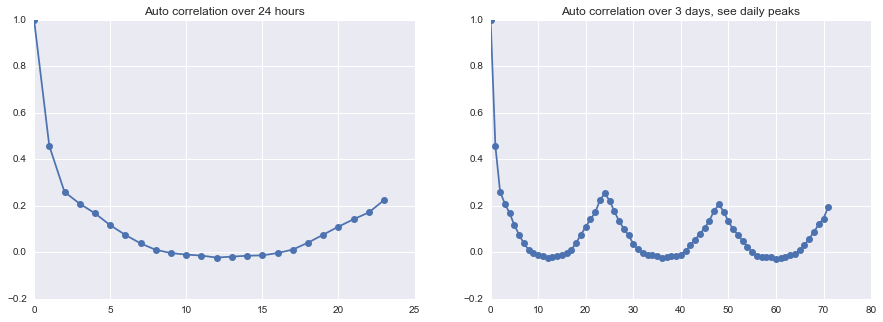

In [49]:
# Now we can test Niquille's intuition. He seems to claim busy hours come in chunks. That should mean that there
# should be correlations over the first few hours. 


pylabtools.figsize(15,5)
plt.subplot(121)
autocorrelations=pd.Series([nd_merged.busy.autocorr(lag=l) for l in range(24)])
plt.plot(pd.rolling_mean(autocorrelations,1),"-o")
plt.title("Auto correlation over 24 hours")

plt.subplot(122)
autocorrelations=pd.Series([nd_merged.busy.autocorr(lag=l) for l in range(3*24)])
plt.plot(pd.rolling_mean(autocorrelations,1),"-o")

plt.title("Auto correlation over 3 days, see daily peaks")

In [50]:
total_lag_hours=48
for i in range(1,total_lag_hours+1):
    nd_merged['lag'+str(i)]=nd_merged.busy.shift(i)

cols=['lag'+str(i) for i in range(1,total_lag_hours+1) ]

In [51]:
# We cant use the first 'total_lag_days' as they do not have complete information accroding to the above model
nd_final=nd_merged[total_lag_hours:]

In [135]:
nd_final.head()

,delta_time,date,month,day,time_bin,delta_date,total,number_ambulances_engaged,total_calls,mu,...,lag39,lag40,lag41,lag42,lag43,lag44,lag45,lag46,lag47,lag48
48,48,2004-01-03,1,5,0,2,4,4,1,4.288889,...,0,0,0,0,0,0,0,0,0,0
49,49,2004-01-03,1,5,1,2,3,3,2,3.888889,...,0,0,0,0,0,0,0,0,0,0
50,50,2004-01-03,1,5,2,2,2,2,1,3.000000,...,0,0,0,0,0,0,0,0,0,0
51,51,2004-01-03,1,5,3,2,2,2,0,2.244444,...,0,0,0,0,0,0,0,0,0,0
52,52,2004-01-03,1,5,4,2,1,1,0,2.266667,...,0,0,0,0,0,0,0,0,0,0


In [53]:
y=nd_final.busy.values

In [54]:
numerical_cols=[]
catecorical_cols=cols+['day','month','time_bin']
X_numerical=nd_final[numerical_cols].values
X_categorical=nd_final[catecorical_cols].values

In [55]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
enc.fit(X_categorical)
X_categorical=enc.transform(X_categorical).toarray()

In [56]:
X=np.hstack((X_numerical,X_categorical))

In [57]:
from sklearn.cross_validation import train_test_split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [122]:
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [129]:
clf=XGBClassifier(n_estimators=1000,learning_rate =0.1,max_depth=5)
#clf=LogisticRegression()
#clf=SVC()
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [130]:
y_pred_rt = clf.predict_proba(X_test)[:, 1]

In [131]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

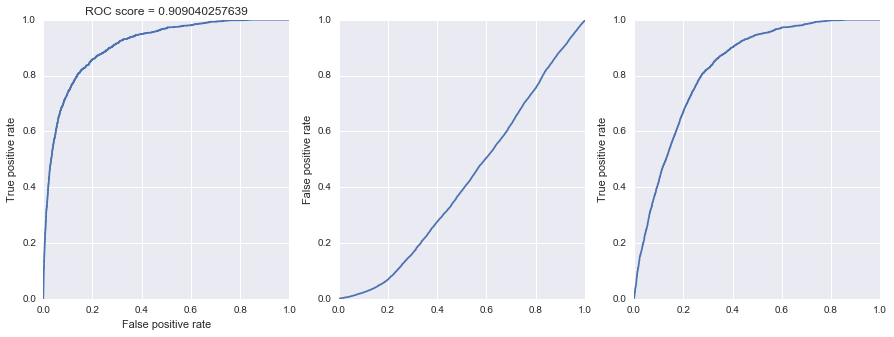

In [132]:
pylabtools.figsize(15,5)

plt.subplot(131)
plt.plot(fpr_rt_lm, tpr_rt_lm)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC score = "+str(roc_auc_score(y_test, y_pred_rt)))
plt.subplot(132)
plt.plot(np.linspace(0,1,fpr_rt_lm.shape[0]),fpr_rt_lm)
plt.ylabel('False positive rate')
plt.subplot(133)
plt.plot(np.linspace(0,1,fpr_rt_lm.shape[0]),tpr_rt_lm)
plt.ylabel('True positive rate')

(array([ 153.,  118.,   11.,    3.,    4.,    2.,    2.,  133.,  123.,
         388.,  829.,  793.,  582.,  413.,  377.,  355.,  276.,  173.,
          98.,   24.,  195.,   93.,   48.,   26.]),
 array([  0.        ,   0.95833333,   1.91666667,   2.875     ,
          3.83333333,   4.79166667,   5.75      ,   6.70833333,
          7.66666667,   8.625     ,   9.58333333,  10.54166667,
         11.5       ,  12.45833333,  13.41666667,  14.375     ,
         15.33333333,  16.29166667,  17.25      ,  18.20833333,
         19.16666667,  20.125     ,  21.08333333,  22.04166667,  23.        ]),
 <a list of 24 Patch objects>)

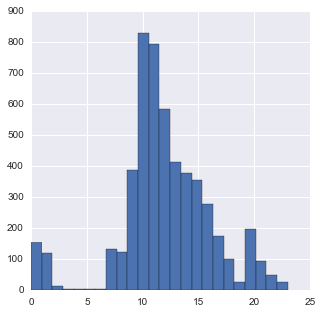

In [80]:
plt.hist(nd_final[nd_final.busy==1].time_bin,bins=24)

In [91]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,np.where(y_pred_rt>.18,1,0))

array([[26081,  1147],
       [  708,   981]])

In [93]:
1.0*confusion_matrix(y_test,np.where(y_pred_rt>.18,1,0))[1,1]/np.sum(y_test==1) ## true positive rate

0.5808170515097691

In [95]:
1.0*confusion_matrix(y_test,np.where(y_pred_rt>.18,1,0))[0,0]/np.sum(y_test==0) ## true negative rate

0.957874247098575

In [141]:
a=nd_final.busy[1:]
b=nd_final.busy[:-1]

from scipy.stats import spearmanr

spearmanr(a,b)

SpearmanrResult(correlation=0.45722925104382889, pvalue=0.0)